[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab7_style_transfer.ipynb)

# Deep Learning Part 5: Style Transfer

In this section, you will implement the style transfer algorithm proposed by [Gatys et. al. (2016)](https://arxiv.org/pdf/1508.06576.pdf). Your goal is to produce an image that has the high-level content of one image and the low-level style of another.

To perform style transfer, we will use a neural network as a feature extractor to determine style and content features, and we will optimize an image to reach a balance of the chosen style and content. Note that the network does not generate the final image, nor is the network trained at any point in this section; instead of training network weights, we train the image itself. Through this section, you will experience another way to use neural networks and see how deep learning can be used to optimize structures other than neural networks.

Here's an additional example of style transfer:

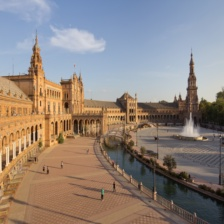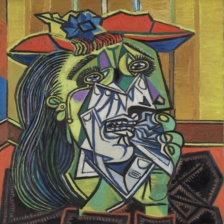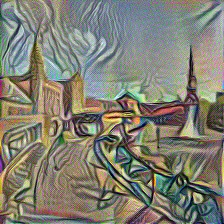

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from torch.nn.parameter import Parameter
from PIL import Image
import io

# IF NOT USING COLAB: comment out the following import statement:
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Select two images: one for content and one for style. The images should have noticeably different content and style from each other to make it clear if the style transfer worked.

In [2]:
# Use this code to upload your own images.
# NOTE: if you are not using Colab, `upload()` will not work. Just make sure the images are on your file system and set `content_path` and `style_path` accordingly.

load_and_normalize = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving jungle2.jpg to jungle2.jpg

Upload Style Image


Saving cyber.jpg to cyber.jpg
Content Path: <_io.BytesIO object at 0x7a2681464950>
Style Path: <_io.BytesIO object at 0x7a275bd08810>


In [68]:
# Load in and normalize the images
# content_path = "jungle.jpg"
# style_path = "cyber.jpg"
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(content_image_orig).unsqueeze(0).to(device)
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(style_image_orig).unsqueeze(0).to(device)


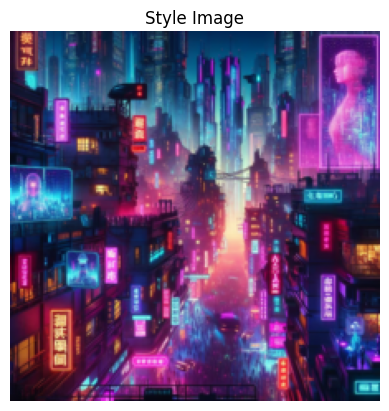

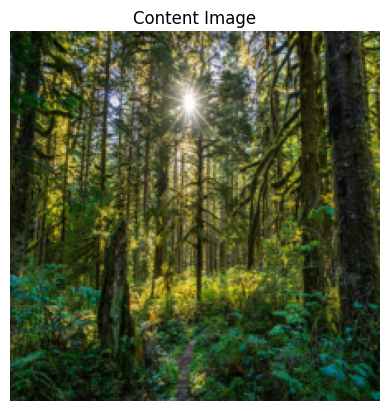

In [69]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

## Part 1

We will use a pretrained VGG-16 network as a feature extractor to get the style and content statistics from the images.

We provide you with the `VGGIntermediate` class to load in the pretrained model and to grab intermediate layers.



* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [70]:
import torchvision.models as models

# You should not have to change any of the code in the following classes.

# Normalization layer normalizes the image pixels to mean=0 std=1 according to the statistics of the ImageNet training dataset (which the VGG was pretrained on)
class Normalization(nn.Module):
  def __init__(self):
      super(Normalization, self).__init__()
      self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
      self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

  def forward(self, img):
      return (img - self.mean) / self.std

# Wrapper for the pretrained VGG-16. Instead of returning the output of the VGG, it returns the `requested` layers.
class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          # This stores the output of the requested layer as `intermediates[i]`
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.intermediates = {}
    self.vgg(self.norm(x))
    return self.intermediates.copy()

We provide you with the list of VGG-16 layer names. Select the names of the layers you'd like to use to extract the content and style ([Gatys et. al. (2016)](https://arxiv.org/pdf/1508.06576.pdf) has suggestions on which layers to use).

Save the layer indexes (not names) into a list for the `requested` parameter of `VGGIntermediate`.

In [71]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

In [72]:
style_indicies = [0, 5, 10, 17, 24]
content_indicies = [19]

Create a `VGGIntermediate` object, providing it with the intermediate layers. You can use a single network to extract both the content and the style, but be sure to keep track of which layers are which.

In [73]:
vgg = VGGIntermediate(style_indicies + content_indicies).to(device)

Use your `VGGIntermediate` network to extract the content from `content_image` and the style from `style_image`. Save these tensors: they will be used throughout training! Be sure to detach these tensors, since these are our labels and we don't want to backpropagate with respect to them.

In [74]:
# Get the information from the content image and style image and then detatch them
all_content_outputs = vgg(content_image)
all_style_outputs = vgg(style_image)
content_outputs = {}
style_outputs = {}
for i in content_indicies:
    content_outputs[i] = all_content_outputs[i].detach()
for i in style_indicies:
    style_outputs[i] = all_style_outputs[i].detach()

---

## Part 2

The loss functions are key to learning the correct behavior in any machine learning problem. For style transfer, we have two losses: content loss and style loss. Our final loss is a combination of both to provide a balance between these competing objectives.

Show that you understand style transfer by describing the key equations of [Gatys et al. 2016](https://arxiv.org/pdf/1508.06576.pdf) in your own words. You may need to read the surrounding sections to understand the equations.

Content Loss:

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English. Include the meaning of all variables and what each dimension represents for each matrix and vector variable.

$\mathcal{L}_{content}(\vec{p}, \vec{x}, l) = \frac{1}{2}\sum_{i,j} (F^l_{ij} - P^l_{ij})^2$

This Equation gives us the overall loss score for content similarity. It is large when the high-level features in the generated image doesn’t match the content image, and it's small when it does match. $l$ is the specific layer we are choosing to match the content to, $p$ is the original content image, and $x$ is the genereated image we are trying to match to $p$. If we pass $x$ through our forward pass of the CNN, at layer $l$ we will get activation values for each receptive field $j$ (like a pixel) of each channel $i$. These activation values found on the forward pass of our generated image $x$ are represented by $F_{ij}^{l}$. Likewise, if we pass our content image $p$ through the CNN, we will also get activation values $P_{ij}^{l}$. It essentially penalizes differences in these activations at a squared rate, and adds all squared differences together, scaling by one-half.

Style Loss:

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and what each dimension represents for each matrix and vector variable (including the output).

$G^l_{ij} = \sum_k F^l_{ik} F^l_{jk}$

As we already defined $F_{ik}^{l}$ in the previous answer, we only have left to define $G_{ij}^{l}$ as the gram matrix, being a matrix of size $N_l$ by $N_l$ (the number of channels for layer $l$). In plain english, this essentially measures the similarity between all output channels at layer $l$. In other words, it is a correlation matrix, showing which channels will have similar and different activations. In more techinical terms, we measure similarity between channels by taking any two channels and multiplying together receptive field by receptive field (pixel by pixel), then add all of these multiplied values together, also known as an inner product. So $G_{ij}^{l}$ (the gram matrix) is a sort of correlation between channels at layer $l$. This preserves correlation can also be seen as style similarity.


- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and what each dimension represents for each matrix and vector variable.

$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j} (G^l_{ij} - A^l_{ij})^2$

We have already defined $G_{ij}^{l}$ and $N_l$ so we are left to define $A_{ij}^{l}$. $A_{ij}^{l}$ is simply the same style correlation matrix as $G_{ij}^{l}$, only it is applied to the original image with style information. By taking the differences in these correlation matrices, penalizing differences by the square, and adding them together. We are essentially saying that we want our image to produce activations that correlate in the same way that our style image does. In other words, for layer $l$, we want our different filters of our image to relate to each other in the same way that the style guide did. We also introduce $M_l$, the number of receptive fields (like pixels) in each channel as a normalizing constant.


- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$\mathcal{L}_{style}(\vec{a}, \vec{x}) = \sum^L_{l=0} w_lE_l$

$E_l$ as described above, is the overall style dissimilarity of a single layer, represented by the differences in filter covariances between style guide and input image. We introduce $w_l$ as a weight of the layer $l$, and perform a weighted sum of these layerwise losses, making this equation represent the overall style loss found from our input image and our style image. $a$ is the style image being passed into $E_l$ and $x$ is the generated image being passed into $E_l$

___

## Part 3
Now that you understand the loss functions mathematically, create modules that calculate the content and style loss for a single content or style layer.

Since the targets will be static throughout learning (the content and style images don't change, nor the network), we can store them in the loss module objects, so we don't have to pass them into the forward each time.

In [75]:
# Produces a gram matrix from a 4D tensor input
def gram_matrix(F):
    B, C, H, W = F.size()
    F = F.view(B, C, H * W)
    G = torch.bmm(F, F.transpose(1, 2))
    return G


# Represents the content loss function for a single content layer
class ContentLoss(nn.Module):
  # Since the targets don't change, store the targets in the init
  def __init__(self, target):
      super().__init__()
      self.target = target.detach()

  def forward(self, y_hat):
      return F.mse_loss(y_hat, self.target) / 2

# Represents the style loss function for a single style layer
class StyleLoss(nn.Module):
  def __init__(self, target):
      super().__init__()
      B, C, H, W = target.size()
      self.N = C
      self.M = H * W
      self.target = gram_matrix(target).detach()

  def forward(self, y_hat):
      a_matrix = gram_matrix(y_hat)
      scale = 4 * (self.N ** 2 * self.M ** 2)
      return F.mse_loss(a_matrix, self.target) / scale


# Instantiate a content loss module for each content layer with the content reference image outputs for that layer for comparison
content_loss_modules = {i:ContentLoss(content_outputs[i]) for i in content_outputs.keys()}

# Instantiate a style loss module for each style layer with the style reference image outputs for that layer for comparison
style_loss_modules = {i:StyleLoss(style_outputs[i]) for i in style_outputs.keys()}

Now that you have a list of loss modules, write a loss function that computes the combined style transfer loss. You can weight the overall content and style losses, as well as weighting each layerwise loss value.

Return the combined loss as a tensor for learning. Return the content and style loss values for plotting.

In [76]:
def loss(generated_image, content_loss_modules, style_loss_modules, vgg = vgg, alpha = 1.0, beta = 5*1e-3, content_weights = None, style_weights = None,separate = False):
    # Handle the content weights
    if content_weights is None:
        num_content_layers = len(content_loss_modules)
        content_weights = np.ones(num_content_layers) / num_content_layers
    else:
        num_content_layers = len(content_weights)
        if num_content_layers != len(content_loss_modules):
            raise ValueError("Number of content weights must match the number of content loss modules")

    # Handle the style weights
    if style_weights is None:
        num_style_layers = len(style_loss_modules)
        style_weights = np.ones(num_style_layers) / num_style_layers
    else:
        num_style_layers = len(style_weights)
        if num_style_layers != len(style_loss_modules):
            raise ValueError("Number of style weights must match the number of style loss modules")

    # Get the forward pass of the generated image
    forward = vgg(generated_image)
    content_keys = content_loss_modules.keys()
    style_keys = style_loss_modules.keys()
    content_forward = {k:forward[k] for k in content_keys}
    style_forward = {k:forward[k] for k in style_keys}


    # Initialize the loss values
    content_loss = 0
    style_loss = 0

    # Calculate the losses
    for i, key in enumerate(content_keys):
        content_loss += content_weights[i] * content_loss_modules[key](content_forward[key])

    for i, key in enumerate(style_keys):
        style_loss += style_weights[i] * style_loss_modules[key](style_forward[key])

    # Weight the losses and add them together
    loss = alpha * content_loss + beta * style_loss
    if separate == True:
        return loss, content_loss, style_loss
    else:
        return loss




___

## Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



First, we need to define our image. While we can create a random image and hope that the optimization works, the best results come from using a clone of the content image. That way, the image starts with the desired content and the content loss only needs to preserve the existing content.

Create a clone of the content image as your initial "generated" image. Calculate and print content and style loss (separately) for your generated image. What do you notice about these losses? Make sure the losses match what you'd expect, given that the generated image is a copy of the content image.

In [77]:
clone = content_image.clone()
loss_val, content_loss, style_loss = loss(clone, content_loss_modules, style_loss_modules, separate = True)
print("Content Loss: {}".format(content_loss))
print("Style Loss: {}".format(style_loss))
print("The content loss is what we expect")


Content Loss: 0.0
Style Loss: 0.011400959454476833
The content loss is what we expect


Prepare your generated image for optimization. You need two things:


1.   Your generated image must require gradients: set requires_grad to true by setting the object parameter `requires_grad` or calling the function `requires_grad_()`.
2.   Create an optimizer with your generated image as the parameter. Torch optimizers expect a list of parameters (or tensors), so you'll need to wrap your generated image in a single-item list for the optimizer.



In [78]:
# Prepare your generated image to learn
clone.requires_grad = True


# Create your optimizer: we suggest starting using an Adam optimizer with lr=.1
optimizer = optim.Adam([clone], lr = .1)

Now create and run your training loop, storing content and style losses as you train. Remember, you will be optimizing the **generated image** according to the content and style statistics extracted with the network. Print your final image.

For best results, use `torch.clamp(generated_im, 0, 1)` to keep your pixel values in range after each learning step.

Style transfer is very susceptible to overtraining, which introduces a lot of noise to the final image. Print your image often during the training process to find the best-looking image.

In [79]:
# create and run your training loop
def make_modules(content_image, style_image, content_indicies, style_indicies):
    # Get the vgg
    vgg = VGGIntermediate(style_indicies + content_indicies).to(device)

    # Get the correct outputs
    all_content_outputs = vgg(content_image)
    all_style_outputs = vgg(style_image)
    content_outputs = {}
    style_outputs = {}
    for i in content_indicies:
        content_outputs[i] = all_content_outputs[i].detach()
    for i in style_indicies:
        style_outputs[i] = all_style_outputs[i].detach()

    # Instantiate a content loss module for each content layer with the content reference image outputs for that layer for comparison
    content_loss_modules = {i:ContentLoss(content_outputs[i]) for i in content_outputs.keys()}

    # Instantiate a style loss module for each style layer with the style reference image outputs for that layer for comparison
    style_loss_modules = {i:StyleLoss(style_outputs[i]) for i in style_outputs.keys()}

    start = content_image.clone()
    start.requires_grad = True
    return start, vgg, content_loss_modules, style_loss_modules



def train(clone, optimizer, content_loss_modules, style_loss_modules, epochs = 1000, vgg = vgg, alpha = 1, beta = 5*1e-3, content_weights = None, style_weights = None):
    content_losses = []
    style_losses = []
    print_steps = 15

    # Loop through the epochs
    loop = tqdm(desc="Training", total=epochs, position=0, leave=True)
    for i in range(epochs):
        optimizer.zero_grad()
        loss_val, content_loss, style_loss = loss(clone, content_loss_modules, style_loss_modules, alpha = alpha, beta = beta, vgg = vgg, content_weights = content_weights, style_weights = style_weights, separate = True)
        loss_val.backward()

        # Take the step and append the losses
        optimizer.step()
        with torch.no_grad():
            clone.clamp_(0, 1)
        content_losses.append(content_loss.item())
        style_losses.append(style_loss.item())

        # update the loop
        loop.set_description('epoch:{}/{}, content_loss:{:.4f}, style_loss:{:.4f}'.format(i+1, epochs, content_loss.item(),style_loss.item()))
        loop.update()

    return clone, content_losses, style_losses

In [86]:
epochs = 500
alpha = 1
beta = 1e5
content_weights = None
style_weights = None
lr = .01
style_indicies = [0, 5, 10, 17, 24]
content_indicies = [19]

# Show the parameters
layer_names = np.array(vgg_names)
print("Content Layers: {}".format(layer_names[content_indicies]))
print("Style Layers: {}".format(layer_names[style_indicies]))
print("Alpha: {}".format(alpha))
print("Beta: {}".format(beta))
print("Content Weights: {}".format(content_weights))
print("Style Weights: {}".format(style_weights))
print("Learning Rate: {}".format(lr))
print("\n")

# Make the modules, initialize the optimizer, and generate the new image and style losses.
clone, vgg, content_loss_modules, style_loss_modules = make_modules(content_image, style_image, content_indicies, style_indicies)
optimizer = optim.Adam([clone], lr = lr)
new_image, content_losses, style_losses = train(clone,optimizer,content_loss_modules,style_loss_modules, epochs = epochs, alpha = alpha, beta = beta, content_weights = content_weights, style_weights = style_weights)

Content Layers: ['conv4_2']
Style Layers: ['conv1_1' 'conv2_1' 'conv3_1' 'conv4_1' 'conv5_1']
Alpha: 1
Beta: 100000.0
Content Weights: None
Style Weights: None
Learning Rate: 0.01




epoch:500/500, content_loss:14.8107, style_loss:0.0001: 100%|██████████| 500/500 [00:13<00:00, 38.05it/s]


Plot your content and style losses. Content loss should start at 0 and increase as style loss decreases. They should both reach an equilibrium.

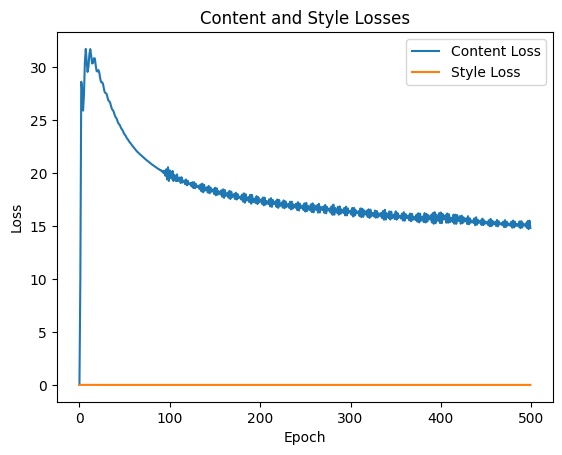

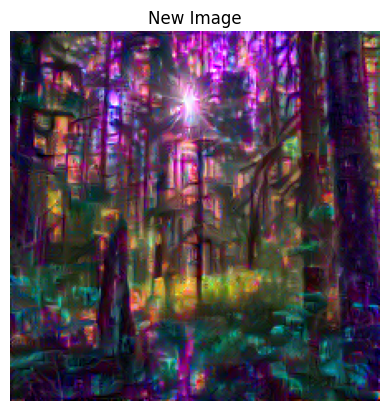

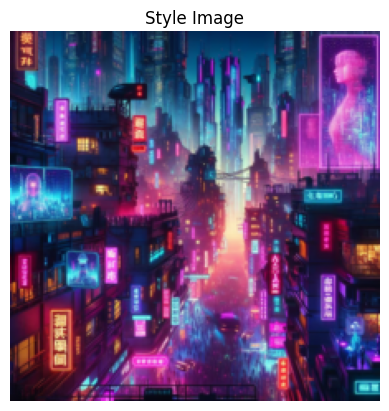

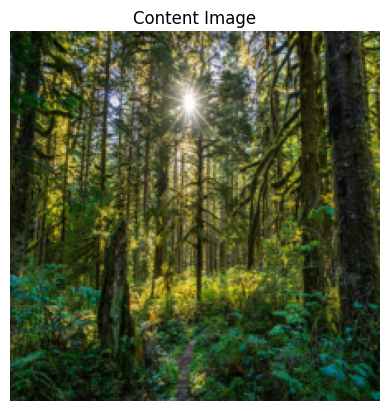

In [87]:
# plot the content and style losses
plt.plot(content_losses, label = "Content Loss")
plt.plot(style_losses, label = "Style Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Content and Style Losses")
plt.legend()
plt.show()

# Show all images
display(new_image, title='New Image')
display(style_image, title='Style Image')
display(content_image, title='Content Image')


Now that you have style transfer working, the results may not look very appealing. Different content and style images require different hyperparameters, so you should play around with different network layers, learning rates, and loss weighting to get the best results.